### Import packages.

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import math

### Instantiate molecular descriptor calculator.

In [2]:
nms=[x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)

### Training data.
1. read data
2. calculate descriptors for each molecule
3. add descriptors to molecular records
4. curate descriptors
  * retain only numeric descriptors
  * build descriptor (X) dataframe, and endpoint (y) dataframe

In [3]:
file_in = "data/TR_WS_3158.sdf"
file_out = "cache/TR_WS_3158"+".descr.sdf"

ms = [x for x in Chem.SDMolSupplier(file_in) if x is not None]

ms_wr = Chem.SDWriter(file_out)

for i in range(len(ms)):
    descrs = calc.CalcDescriptors(ms[i])
    for x in range(len(descrs)):
        ms[i].SetProp(str(nms[x]),str(descrs[x]))
        
    ms_wr.write(ms[i]) 
        
frame = PandasTools.LoadSDF("cache/TR_WS_3158.descr.sdf")       

frame = frame[frame.columns.drop(['ROMol'])]

frame.to_csv('cache/TR_WS_3158.descr.csv')
train = pd.read_csv('cache/TR_WS_3158.descr.csv')
train = train[train.columns.drop(['Unnamed: 0', 'CAS', 'Canonical_QSARr', 'ID', \
                                  'InChI Key_QSARr', 'InChI_Code_QSARr', \
                                  'NAME', 'SMILES', 'Salt_Solvent', 'WS Reference', \
                                  'dsstox_substance_id', 'iupac', 'preferred_name'])]
train = train.dropna()

X_train = train[train.columns.drop(['LogMolar'])]
y_train = train[['LogMolar']]

In [6]:
train.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,LogMolar,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,WS Temperature,qed
0,2.000000,2.000000,2.000000,1.115355,1.115355,1.000000,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,0.000000,4.794537,30.010565,1.500000,1.500000,1.500000,0.000000,-0.33,2.0,28.010,2.000000e+00,1.670000,0.670000,-5.360303,12.900773,1.1206,8.000000,0.307097,8.000000,0.106382,2.000000,0.106382,2.000000,-0.307097,-0.1849,7.1210,30.026,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0.0,0.0,0.0,0.0,12,4.794537,6.789076,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.794537,6.789076,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,6.789076,4.794537,0.000000,0.000000,0.000000,0.0,0.0,0.0,17.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,10.000000,20.0,0.360624
1,1.837692,804.748825,20.698306,16.613088,16.613088,12.963233,10.142335,10.142335,9.749151,9.749151,8.791253,8.791253,7.261033,7.261033,52.429697,24.908657,4.390415,18.121973,24.835569,0.000000,12.152040,26.847232,0.000000,0.000000,0.000000,392.199902,1.321429,2.000000,2.642857,0.727273,-1.37,28.0,363.235,1.500076e+06,19.925309,5.832748,2.014264,163.871786,-3.7077,16.859063,0.389712,16.859063,0.189906,0.067556,0.189906,-1.980464,-0.389712,1.8957,99.9444,392.467,3.0,5.0,4.0,0.0,4.0,0.0,0.0,0.0,5.0,3.0,6.0,0,2.0,3.0,0.0,3.0,154,15.319582,12.207933,17.235250,0.000000,0.0,0.000000,9.589074,4.390415,0.0,0.0,25.496599,56.594876,16.747887,6.103966,4.0,29.299072,11.566490,0.0,0.000000,28.583699,63.828275,6.606882,23.801165,0.0,0.0,0.000000,4.390415,0.0,0.0,50.866731,9.589074,28.583699,46.454498,23.801165,0.0,0.0,0.0,94.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.859063,57.974270,25.0,0.667213
2,1.654620,786.237565,21.189870,17.571026,17.571026,13.526347,10.837743,10.837743,10.179483,10.179483,8.916186,8.916186,7.436803,7.436803,35.479440,24.596666,0.000000,28.951954,19.262465,31.256391,6.923737,6.076020,6.923737,6.923737,4.736863,404.219889,1.206897,1.931034,2.620690,0.782609,-1.53,29.0,372.247,2.615371e+06,20.731066,6.741324,2.857980,171.241629,-4.4577,12.870043,0.457742,12.870043,0.302566,0.041293,0.302566,-1.584704,-0.457742,2.3524,104.6896,404.503,2.0,6.0,4.0,0.0,4.0,0.0,0.0,0.0,6.0,2.0,6.0,0,3.0,3.0,0.0,3.0,160,14.949918,5.601051,12.390127,5.783245,0.0,5.969305,14.383612,0.000000,0.0,0.0,19.420579,67.769658,18.759549,6.103966,4.0,29.333529,17.535795,0.0,0.000000,28.583699,77.421980,6.606882,11.649125,0.0,0.0,0.000000,0.000000,0.0,0.0,46.060749,19.120475,28.583699,65.716963,11.649125,0.0,0.0,0.0,100.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,

In [8]:
type(train)

pandas.core.frame.DataFrame

In [10]:
train.shape

(2765, 117)

In [11]:
frame.shape

(3158, 129)

### Test data.
1. read data
2. calculate descriptors for each molecule
3. add descriptors to molecular records
4. curate descriptors
  * retain only numeric descriptors
  * build descriptor (X) dataframe, and endpoint (y) dataframe

In [4]:
file_in = "data/TST_WS_1066.sdf"
file_out = "cache/TST_WS_1066"+".descr.sdf"

ms = [x for x in Chem.SDMolSupplier(file_in) if x is not None]

ms_wr = Chem.SDWriter(file_out)

for i in range(len(ms)):
    descrs = calc.CalcDescriptors(ms[i])
    for x in range(len(descrs)):
        ms[i].SetProp(str(nms[x]),str(descrs[x]))
        
    ms_wr.write(ms[i]) 
        
frame = PandasTools.LoadSDF("cache/TST_WS_1066.descr.sdf")       

frame = frame[frame.columns.drop(['ROMol'])]

frame.to_csv('cache/TST_WS_1066.descr.csv')
test = pd.read_csv('cache/TST_WS_1066.descr.csv')
test = test[test.columns.drop(['Unnamed: 0', 'CAS', 'Canonical_QSARr', 'ID', \
                               'InChI Key_QSARr', 'InChI_Code_QSARr', \
                               'NAME', 'SMILES', 'Salt_Solvent', 'WS Reference', \
                               'dsstox_substance_id', 'iupac', 'preferred_name'])]
test = test.dropna()
X_test = test[test.columns.drop(['LogMolar'])]
y_test = test[['LogMolar']]

### Identify / remove near-zero variance decriptors.

In [5]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

nzv = variance_threshold_selector(X_train, 0.05)

X_train = X_train[nzv.columns]
X_test = X_test[nzv.columns]

### Identify / remove highly correlated descriptors.

In [6]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns
           if any(upper[column] > 0.85)]

X_train = X_train[X_train.columns.drop(to_drop)]
X_test = X_test[X_test.columns.drop(to_drop)]

### Standardize features by removing the mean and scaling to unit variance.

In [7]:
#### StandardScaler: mean=0, variance=1

scaler = StandardScaler()
scaler.fit(X_train)

X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_train)

### Random forest regression.

In [8]:
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import matplotlib.pyplot as plt

forest = RandomForestRegressor(50)
conv_arr= y_train.values
y_train_array = conv_arr.ravel()
forest.fit(X_train, y_train_array)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Predict outcomes for test set; plot result.

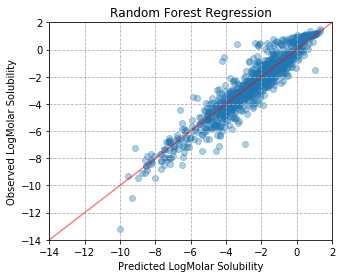

In [9]:
y_predict = forest.predict(X_test)

conv_arr= y_test.values
y_test_array = conv_arr.ravel()

fig, ax = plt.subplots()
ax.scatter(y_predict, y_test_array, alpha = 0.35)

y_lower = math.floor(min(y_test_array))
y_upper = math.ceil(max(y_test_array))
x_lower = math.floor(min(y_predict))
x_upper = math.ceil(max(y_predict))
lower = min(x_lower, y_lower)
upper = max(x_upper, y_upper)

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_xlim((lower, upper))
ax.set_ylim((lower, upper))
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', linestyle='--')

init, final = [lower, upper], [lower, upper]

ax.set_title('Random Forest Regression')
ax.set_xlabel('Predicted LogMolar Solubility')
ax.set_ylabel('Observed LogMolar Solubility')

plt.plot(init, final, color = 'red', alpha = 0.5)